In [ ]:
!pip install fastai --upgrade -q


In [ ]:
import torch 
GPU_AVAILALBE = True if  torch.cuda.device_count()>0 else False


In [ ]:
cat_var = "articleType"
import pandas as pd
from copy import deepcopy
from fastai.vision.all import *
import os

In [ ]:
arch = 'resnet18'
_arch = resnet18 if arch == 'resnet18' else resnet50
bs = 128 if arch == 'resnet18' else 32

from sklearn.model_selection import train_test_split

In [ ]:
# create a local folder in your session (here's were the images are going)
try:
  if os.getcwd()=='/content':
    os.mkdir('fashion')
except:
  pass
if os.getcwd()=='/content':
  os.chdir('fashion')
from fastai.vision.all import *

In [ ]:
# connect to google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [ ]:
#unzip all images to the current working directory
#!unzip /content/gdrive/MyDrive/Data/fashion_database/fashion_small.zip

Archive:  /content/gdrive/MyDrive/Data/fashion_database/fashion_small.zip
replace images/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

               path category
0  images/15970.jpg   Shirts
1  images/39386.jpg    Jeans
2  images/59263.jpg  Watches
4  images/53759.jpg  Tshirts
5   images/1855.jpg  Tshirts


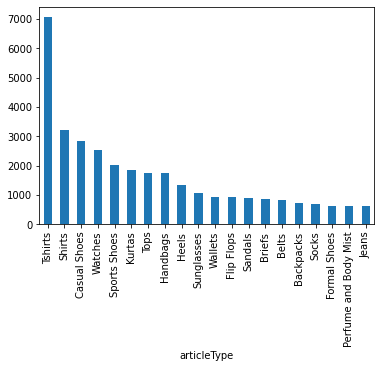

In [ ]:
# prepare df
def prep_df(df,fname_col, path=None):
  if path is None: 
    fnames = os.listdir()
  else:
    fnames = os.listdir(path)
  df['fname'] = df[fname_col].apply(lambda x: str(x)+'.jpg')
  return deepcopy(df[df['fname'].isin(fnames)])


def get_categories(df, variable:str, n:int):
  Categories = df.groupby(by=variable).size()
  Categories = Categories.sort_values(ascending=False).head(n)
  Categories.plot.bar()
  df = deepcopy(df[df[variable].isin(Categories.index.values)])
  df.rename(columns={variable:'category'}, inplace=True)
  return pd.DataFrame(Categories), df

styles = pd.read_csv('styles.csv',error_bad_lines=False)

df = prep_df(styles,'id','images')
categories ,df = get_categories(df,cat_var,n=20)
df['path'] = df['id'].apply(lambda x: 'images/'+ str(x)+'.jpg')
df = df[['path', 'category']]
print(df.head())

# put 10 percent of the set apart


In [ ]:
train,val, df_test = split_stratified_into_train_val_test(df, stratify_colname='category',frac_train=0.6,frac_val=0.2, frac_test = 0.2)

In [ ]:
df = pd.concat([train,val])
del train,val

In [ ]:
#df = deepcopy(df.sample(1000))

In [ ]:
# create datablocks and load data
dblock = DataBlock(blocks=(ImageBlock , CategoryBlock) ,
                   get_x=ColReader(0) , 
                   get_y = ColReader(1) ,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms = RandomResizedCrop(256 , min_scale=0.5))
dls = dblock.dataloaders(df,bs=bs)


In [ ]:
precision = Precision(average='micro')

# define learner
if GPU_AVAILALBE:
  learn = cnn_learner(dls, _arch, opt_func=ranger,  metrics=precision)
else:
  learn = cnn_learner(dls, _arch, opt_func=ranger,  metrics=accuracy)


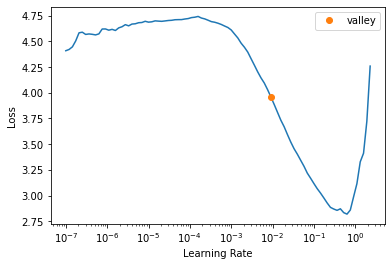

In [ ]:
# get learning rate
lr = learn.lr_find()[0]



In [ ]:
# train last layer of frozen network
learn.fit_one_cycle(20,lr)

epoch,train_loss,valid_loss,precision_score,time
0,0.713096,0.752421,0.775000,00:06
1,0.733131,0.740293,0.780000,00:06
2,0.732669,0.725440,0.780000,00:06
3,0.719705,0.720307,0.785000,00:06
4,0.669681,0.686481,0.790000,00:06
5,0.621859,0.662257,0.790000,00:06


In [ ]:
# make predictions on test_df with frozen network
test_dl = dls.test_dl(test_df, with_labels=True)
preds = learn.get_preds(dl=test_dl)
print(learn.validate(dl=test_dl))
print(f'accuracy: {accuracy(preds[0], preds[1])}')

[2.5486271381378174, 0.23257918655872345]
accuracy: 0.23257918655872345


In [ ]:
# unfreeze network so all layers are trainable

learn.unfreeze()
learn.fit_one_cycle(50,lr_max=slice(1e-6,1e-2),cbs=[EarlyStoppingCallback(monitor='Precision', min_delta=0.001, patience=20),SaveModelCallback('Precision')])

epoch,train_loss,valid_loss,accuracy,time
0,3.475964,2.278659,0.350000,00:09
1,2.975034,1.710008,0.525000,00:07


Better model found at epoch 0 with accuracy value: 0.3499999940395355.
Better model found at epoch 1 with accuracy value: 0.5249999761581421.


In [ ]:
# analyze results:
interp = ClassificationInterpretation.from_learner(learn)
preds = learn.get_preds(dl=test_dl)
print(learn.validate(dl=test_dl))
print(f'accuracy: {'accuracy(preds[0], preds[1])}')

interp.plot_confusion_matrix(figsize=(10, 10))

In [ ]:
# export model
learn.export(os.path.abspath(f'./models/{arch}_{cat_var}.pkl'))
